In [1]:
import pandas as pd
import numpy as np
import datetime
import scipy
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display, HTML
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, log_loss
from scipy.special import logit
from IPython.display import display, Math

import warnings
warnings.filterwarnings("ignore")

Информация по датасету:

* date_time - время показа рекламы
* oaid_hash - хэш юзера
* zone_id - id зоны, где зона - место на сайте для размещения рекламы
* banner_id - id баннера, где баннер - сама реклама
* campaign_clicks - общее количество показов данной кампании (которой соотвествует баннер) данному юзеру, произошедшие до текущего показа. Кампанию стоит понимать как что-то общее (рекламодатель/тематика/ и т. п.) для баннеров.
* os_id - id операционной системы
* country_id - id страны
* banner_id0 - нулевой баннер в “стакане” баннеров
* banner_id1 - перый баннер в “стакане” баннеров
* rate0 - стоимость 1 клика установленная рекламодателем для banner_id0
* rate1 - стоимость 1 клика установленная рекламодателем для banner_id1
* g0 - стандартное отклонение предикта с banner_id0
* g1 - стандартное отклонение предикта с banner_id1
* coeff_sum0 - сумма коэффициентов для banner_id0
* coeff_sum1 - сумма коэффициентов для banner_id1
* impressions - был ли показ
* clicks - был ли клик


Колонка campaign_clicks для данного задания не нужна

In [2]:
data = pd.read_csv('data.csv', parse_dates=['date_time'],infer_datetime_format=True)

#удаляем признаки,которые не будем использовать
columns_to_drop = ['campaign_clicks', 'rate0', 'rate1','impressions','oaid_hash']
data.drop(columns_to_drop, axis=1, inplace = True)
data.head()

,date_time,zone_id,banner_id,os_id,country_id,banner_id0,g0,coeff_sum0,banner_id1,g1,coeff_sum1,clicks
0,2021-09-27 00:01:30,0,0,0,0,1240,0.035016,-7.268846,0,0.049516,-5.369901,1
1,2021-09-26 22:54:49,1,1,0,1,1,0.054298,-2.657477,269,0.031942,-4.449220,1
2,2021-09-26 23:57:20,2,2,0,0,2,0.014096,-3.824875,21,0.014906,-3.939309,1
3,2021-09-27 00:04:30,3,3,1,1,3,0.015232,-3.461357,99,0.050671,-3.418403,1
4,2021-09-27 00:06:21,4,4,1,0,4,0.051265,-4.009026,11464230,0.032005,-2.828797,1


In [3]:
def analysis(data: pd.DataFrame):
    feat_list = ['banner_id0','banner_id1', 'g0','g1','coeff_sum0', 'coeff_sum1']
    font_size = "20px"
    text ='Описательные характеристики'
    print('\n')
    display(HTML(f"<p style='font-size: {font_size}'>{text}</p>"))

    print('\nЧисло пропусков в данных:')
    display(pd.DataFrame(data[feat_list].isnull().sum()))

    print('\nЧисло уникальных значений в столбцах:')
    display(pd.DataFrame(data[feat_list[:2]].nunique()))

    print('\nОписательные статистики:')
    display(data[feat_list].describe())


# Проанализируем признаки, которые не рассматривались ранее

In [4]:
analysis(data)


Число пропусков в данных:


,0
banner_id0,0
banner_id1,0
g0,69
g1,19744
coeff_sum0,69
coeff_sum1,19744



Число уникальных значений в столбцах:


,0
banner_id0,946937
banner_id1,3160859



Описательные статистики:


,banner_id0,banner_id1,g0,g1,coeff_sum0,coeff_sum1
count,1.582147e+07,1.582147e+07,1.582140e+07,1.580173e+07,1.582140e+07,1.580173e+07
mean,6.571314e+05,2.605069e+06,7.440764e-01,5.485722e-01,-3.979590e+00,-3.968883e+00
std,2.606008e+06,5.230253e+06,1.670358e+01,1.419136e+01,1.143982e+00,1.186403e+00
min,0.000000e+00,0.000000e+00,-1.763740e-02,-6.983897e-02,-8.588970e+00,-9.562188e+00
25%,7.300000e+01,9.900000e+01,1.643856e-02,1.615219e-02,-4.515871e+00,-4.529519e+00
50%,3.030000e+02,4.600000e+02,3.539307e-02,3.556666e-02,-3.921164e+00,-3.928674e+00
75%,7.200000e+02,1.236000e+03,8.022935e-02,7.546751e-02,-3.421280e+00,-3.390867e+00
max,1.146423e+07,1.462360e+07,6.910888e+02,6.910885e+02,3.149981e-01,4.756181e-01


Из анализа видим, что в новых признаках:
* появляются пропуски
* есть кейсы, где стандартное отклонение меньше нуля, что странно

In [5]:
def feature_engineering(data: pd.DataFrame) -> pd.DataFrame:
    # фильтруем по условию, чтобы banner_id0 совпадал с banner_id
    data = data[data['banner_id0'] == data['banner_id']]
    # фильтруем данные где ст.откл. меньше нуля
    data = data[(data['g0'] > 0) & (data['g1'] > 0)]
    # убираем пропуски в данных
    data = data.dropna()
    # убираем дату с 1 действием
    data = data[~(data.date_time.dt.date == datetime.date(2021, 9, 1))]
    # выделяем дату
    data['date'] = data.date_time.dt.date
    # выделяем день недели
    data['day_of_week'] = data.date_time.dt.dayofweek
    # выделяем время дня
    data['hour'] = data.date_time.dt.hour
    # сгруппируем часы в промежутки дня утро, день, вечер, ночь (утро с 6 до 12, обед с 12 до 18, вечер с 18 до 24, ночь с 24 до 6)
    bins = [0, 6, 12, 18,  24]
    labels = ['Ночь', 'Утро', 'Обед', 'Вечер'] 
    data['time_of_day'] = pd.cut(data['hour'], bins=bins, labels=labels, right=False)
    
    
    #Деление на train-test
    
    # выделяем последний день на test, все остальное на train
    train_data = data[(data.date < datetime.date(2021,10, 2))] 
    test_data = data[(data.date == datetime.date(2021,10, 2))] 
    
    # выделяем категориальные признаки

    categ_feat = ['zone_id', 'os_id', 'country_id','banner_id','hour','day_of_week','time_of_day']

    encoder = OneHotEncoder(drop='first', sparse=True, handle_unknown='ignore')

    X_train = encoder.fit_transform(train_data[categ_feat])
    y_train = train_data['clicks']

    # Тестовые данные для случая, где banner_id == banner_id0
    X_test_0 = encoder.transform(test_data[categ_feat])
    y_test_0 = test_data['clicks']

    # Тестовые данные для случая, где banner_id == banner_id1
    X_test_1 = test_data[categ_feat]
    X_test_1['banner_id'] = test_data['banner_id1']
    X_test_1 = encoder.transform(X_test_1)
    y_test_1 = test_data['clicks']
    
    data_ips = test_data[['g0','g1','coeff_sum0', 'coeff_sum1']]
    
    return X_train, y_train, X_test_0, y_test_0, X_test_1, y_test_1, data_ips

In [6]:
X_train, y_train, X_test_0, y_test_0, X_test_1, y_test_1, data_ips = feature_engineering(data)

## Применяем модель логистической регрессии

In [7]:
model = LogisticRegression(solver="liblinear", penalty="l2", C=0.0001)
model.fit(X_train, y_train)

y_pred = model.predict_proba(X_test_0)[:, 1]

print('Результаты линейной модели:')
print("Log Loss:", log_loss(y_test_0, y_pred))
print("ROC AUC:", roc_auc_score(y_test_0, y_pred))

Результаты линейной модели:
Log Loss: 0.14310167026745282
ROC AUC: 0.7517467835131204


## Clipped IPS

Для того, чтобы посчитать вероятность показа баннера, оценим вероятность:
$P(X_0 > X_1) = P(X_0 - X_1 > 0) = 1 - P(X_0 - X_1 < 0) = 1 - F_{X_0 - X_1}(0) $

Имеем:
$X_0 \sim N(\text{coeff_sum0}, g0^2), X_1 \sim N(\text{coeff_sum1}, g1^2)$

Тогда:
$X_0 - X_1  \sim N(\text{coeff_sum0 - coeff_sum1}, g0^2 + g1^2)$

In [8]:
# Функция для подсчета вероятности
def get_probability(coeff_sum0, coeff_sum1, g0, g1):
    mean = coeff_sum0 - coeff_sum1
    # берем квадрат дисперсии, поскольку надо подставить ст.откл + добавляем 1e-6, чтобы избежать деления на 0
    std = np.sqrt(g0**2 + g1**2) + 1e-6 
    return 1 - scipy.stats.norm.cdf(0, loc=mean, scale=std)

In [9]:
y_pred_0 = model.predict_proba(X_test_0)[:, 1] 
y_pred_1 = model.predict_proba(X_test_1)[:, 1] 

pi_0 = get_probability(data_ips["coeff_sum0"], data_ips["coeff_sum1"], data_ips["g0"], data_ips["g1"])
pi_1 = get_probability(logit(y_pred_0), logit(y_pred_1), data_ips["g0"], data_ips["g1"])

In [10]:
def get_V_cips(y_test, pi_0, pi_1, lamda):
    return np.mean(y_test * np.minimum(pi_1 / (pi_0 + 1e-6), lamda))

In [11]:
lamda = 10
cips = get_V_cips(y_test_0, pi_0, pi_1, lamda)
display(Math(r'$\hat{V}_{CIPS} =' + str(cips)))

<IPython.core.display.Math object>

# Найдем оптимальную регуляризацию по метрике cips

In [12]:
lamda = 10
C = [0.00001,0.00005,0.0001, 0.00015, 0.001, 0.01, 0.1, 0.3]
df_scores = pd.DataFrame(columns=['C', 'Log Loss', 'ROC AUC', 'V_cips'])

for c in C:
    model = LogisticRegression(solver="liblinear", penalty="l2", C=c)
    model.fit(X_train, y_train)

    y_pred = model.predict_proba(X_test_0)[:, 1]
    log_los = log_loss(y_test_0, y_pred)
    roc_auc = roc_auc_score(y_test_0, y_pred)
    y_pred_0 = model.predict_proba(X_test_0)[:, 1] 
    y_pred_1 = model.predict_proba(X_test_1)[:, 1]

    pi_0 = get_probability(data_ips["coeff_sum0"], data_ips["coeff_sum1"], data_ips["g0"], data_ips["g1"])
    pi_1 = get_probability(logit(y_pred_0), logit(y_pred_1), data_ips["g0"], data_ips["g1"])

    cips = get_V_cips(y_test_0, pi_0, pi_1, lamda)

    cur_row = [c,log_los,roc_auc,cips]
    df_scores.loc[len(df_scores)] = cur_row
    print(f'Результаты линейной модели при С = {c}:')
    print("Log Loss:", log_los)
    print("ROC AUC:", roc_auc)
    print("V_cips:", cips)
    print('\n')


Результаты линейной модели при С = 1e-05:
Log Loss: 0.15618691516154504
ROC AUC: 0.6481481432352276
V_cips: 0.0745805770032428


Результаты линейной модели при С = 5e-05:
Log Loss: 0.14580681838255005
ROC AUC: 0.7362224335410936
V_cips: 0.07522413484564369


Результаты линейной модели при С = 0.0001:
Log Loss: 0.14310167026745282
ROC AUC: 0.7517467835131204
V_cips: 0.07555728749988451


Результаты линейной модели при С = 0.00015:
Log Loss: 0.14184644899938217
ROC AUC: 0.7581070355738747
V_cips: 0.07559557889298198


Результаты линейной модели при С = 0.001:
Log Loss: 0.1381414198970599
ROC AUC: 0.7800166727844006
V_cips: 0.0722018569597602


Результаты линейной модели при С = 0.01:
Log Loss: 0.13615313806366316
ROC AUC: 0.7892913337416343
V_cips: 0.06610031232828632


Результаты линейной модели при С = 0.1:
Log Loss: 0.13552465240114048
ROC AUC: 0.7911106276529268
V_cips: 0.06430183461237396


Результаты линейной модели при С = 0.3:
Log Loss: 0.13542147451539427
ROC AUC: 0.791425221586

,C,Log Loss,ROC AUC,V_cips
0,0.00001,0.156187,0.648148,0.074581
1,0.00005,0.145807,0.736222,0.075224
2,0.00010,0.143102,0.751747,0.075557
3,0.00015,0.141846,0.758107,0.075596
4,0.00100,0.138141,0.780017,0.072202
5,0.01000,0.136153,0.789291,0.066100
6,0.10000,0.135525,0.791111,0.064302
7,0.30000,0.135421,0.791425,0.064024


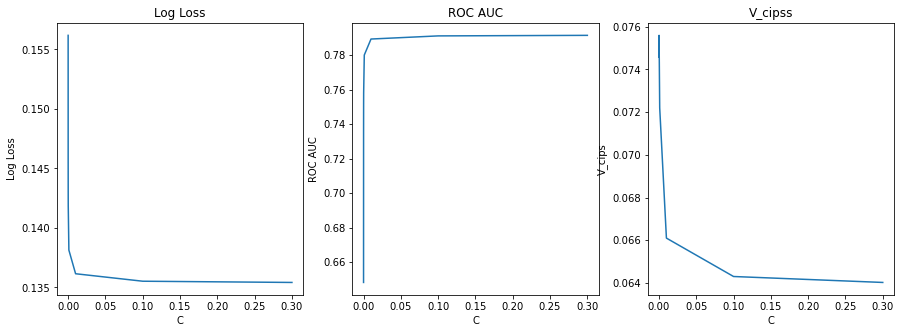

In [13]:
display(df_scores)
# отобразим результаты на графике
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
sns.lineplot(x='C', y='Log Loss', data=df_scores, ax=axes[0])
sns.lineplot(x='C', y='ROC AUC', data=df_scores, ax=axes[1])
sns.lineplot(x='C', y='V_cips', data=df_scores, ax=axes[2])
axes[0].set_title('Log Loss')
axes[1].set_title('ROC AUC')
axes[2].set_title('V_cipss')
plt.show()

#### Рассмотрим участок, где ${V}_{CIPS}$ достигает максимума

,C,Log Loss,ROC AUC,V_cips
0,0.00001,0.156187,0.648148,0.074581
1,0.00005,0.145807,0.736222,0.075224
2,0.00010,0.143102,0.751747,0.075557
3,0.00015,0.141846,0.758107,0.075596
4,0.00100,0.138141,0.780017,0.072202


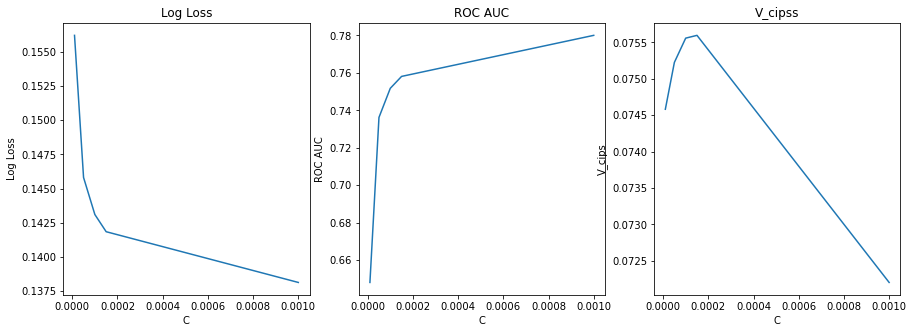

In [14]:
df_scores_new = df_scores.loc[0:4]
display(df_scores_new)
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
sns.lineplot(x='C', y='Log Loss', data=df_scores_new, ax=axes[0])
sns.lineplot(x='C', y='ROC AUC', data=df_scores_new, ax=axes[1])
sns.lineplot(x='C', y='V_cips', data=df_scores_new, ax=axes[2])
axes[0].set_title('Log Loss')
axes[1].set_title('ROC AUC')
axes[2].set_title('V_cipss')
plt.show()

Таким образом, получаем максимальное значение $\hat{V}_{CIPS} =  0.075596 $  при регуляризационном коэффициенте $C = 0.00015$